<center>

# Logic, Learning, and Decision

## Home Assignment 1

### Synchronization and Supervisor Synthesis

- - -

# Introduction

The objective of this home assignment is to get a deeper understanding of some basic features of discrete event systems. This will be achieved by implementing a few key functions in Python, including the computation of coreachable states, the synchronous composition of two automata, as well as the synthesis of a nonblocking and controllable supervisor. These functions are then applied to the analysis of a simple coordination control system.

This home assignment is performed in *two member groups*. Write all your answers into this notebook and **submit only this notebook (.ipynb) containing your team's own original work on Canvas.**

## Comments and Recommendations

* As before, the following resources will be of great help to you for this assignment:
  * Lecture notes
  * [Python docs](https://docs.python.org/3/)
  * [Google](https://www.google.com)
  * [Wikipedia overview of syntax and semantics](https://en.wikipedia.org/wiki/Python_syntax_and_semantics) 
* We will work extensively with **sets** in this assignment: 
  * A set is created either through `set(*iterable*)` or by listing its elements between curly braces `{*iterable*}`; 
  * An empty set must be created by `set()`. `{}` will create an empty dictionary; 
  * You will also see often something like `{elem for elem in items if elem}`. This is called a *set comprehension* and builds efficiently a new set by iterating over `items` and adding the `elem` for which the if-statement is true; 
  * Have an extensive look at [the set documentation](https://docs.python.org/3/library/stdtypes.html#set) for more information on set methods. Use set methods as much as possible.  
* The assignment is written for Python 3.5 or later.
* If your code passes all the tests in this notebook, you are on a good way. That does not mean you have passed though! **We will test your code with additional edge cases.** So, convince yourself that everything is correct before you submit, e.g. *through your own test cases*.

- - -

# Data Structures

As in Assignment 0, we define the Transition and Automaton classes. They are structured the same as previously. We have included, however, a few validation methods that ensure that the Automaton is consistent at all time. You do not need to change anything here, but give it a thorough read anyway.  

In [281]:
from collections import namedtuple

from util import plot_automaton


Transition = namedtuple(typename='Transition', field_names=[
                        'source', 'event', 'target'])


class Automaton(object):

    def __init__(self, states, init, events, trans, marked=None, forbidden=None):
        """
        This is the constructor of the automaton.

        At creation, the automaton gets the following attributes assigned:
        :param states: A set of states
        :param init: The initial state
        :param events: A set of events
        :param trans: A set of transitions
        :param marked: (Optional) A set of marked states
        :param forbidden: (Optional) A set of forbidden states
        """
        self.states = states
        self.init = init
        self.events = events
        self.trans = trans
        self.marked = marked if marked else set()
        self.forbidden = forbidden if forbidden else set()

    def __str__(self):
        """
        Prints the automaton in a pretty way.
        """
        return 'states: \n\t{}\n' \
               'init: \n\t{}\n' \
               'events: \n\t{}\n' \
               'transitions: \n\t{}\n' \
               'marked: \n\t{}\n' \
               'forbidden: \n\t{}\n'.format(
                   self.states, self.init, self.events,
                   '\n\t'.join([str(t) for t in self.trans]), self.marked, self.forbidden)

    def __setattr__(self, name, value):
        """Validates and protects the attributes of the automaton"""
        if name in ('states', 'events'):
            value = frozenset(self._validate_set(value))
        elif name == 'init':
            value = self._validate_init(value)
        elif name == 'trans':
            value = frozenset(self._validate_transitions(value))
        elif name in ('marked', 'forbidden'):
            value = frozenset(self._validate_subset(value))
        super(Automaton, self).__setattr__(name, value)

    def __getattribute__(self, name):
        """Returns a regular set of the accessed attribute"""
        if name in ('states', 'events', 'trans', 'marked', 'forbidden'):
            return set(super(Automaton, self).__getattribute__(name))
        else:
            return super(Automaton, self).__getattribute__(name)

    def __eq__(self, other):
        """Checks if two Automata are the same"""
        if type(other) is type(self):
            return self.__dict__ == other.__dict__
        return False

    @staticmethod
    def _validate_set(states):
        """Checks that states is a set and the states in it are strings or integers"""
        assert isinstance(states, set)
        for state in states:
            assert isinstance(state, str) or isinstance(
                state, int), 'A state must be either of type string or integer!'
        return states

    def _validate_subset(self, subset):
        """Validates the set and checks whether the states in the subset are part of the state set"""
        subset = self._validate_set(subset)
        assert subset.issubset(
            self.states), 'Marked and forbidden states must be subsets of all states!'
        return subset

    def _validate_init(self, state):
        """Checks whether the state is part of the state set"""
        assert isinstance(state, str) or isinstance(
            state, int), 'The initial state must be of type string or integer!'
        assert state in self.states, 'The initial state must be member of states!'
        return state

    def _validate_transitions(self, transitions):
        """Checks that all transition elements are part in the respective sets (states, events)"""
        assert isinstance(transitions, set)
        for transition in transitions:
            assert isinstance(transition, Transition)
            assert transition.source in self.states
            assert transition.event in self.events
            assert transition.target in self.states
        return transitions

- - -

# Task 1

## Reachability ***[1p]***

To start with, we revisit a few of the functions that you have implemented already in the previous assignment. Whereas Assignment 0 was intended to provide you with a test bench for programming in Python and developing algorithmic understanding, this task is to ensure that you got a correct implementation of `reach` for the rest of the assignment. You might be able to copy your previous solution here. 

A reachability algorithm based on set logic is as follows:

**Algorithm 1.** Reachability($\Sigma, \delta, Q_0, Q_x$)

>**let** $k:=0, Q_0 := Q_0 \setminus Q_x$
>
>**repeat**
>
>>$k := k+1$
>>
>>$Q_k := Q_{k-1} \cup \{q^+ \mid \exists q \in Q_{k-1} \wedge \exists \sigma \in \Sigma \wedge \delta(q,\sigma) = q^+ \} \setminus Q_x $
>>
>**until** $Q_k = Q_{k-1}$
>
**return** $Q_k$

This algorithm is a so called fix point operation. We want you to implement a version of this algorithm. Check the lecture notes for further explanation. Other implementations, that use e.g. a recursion, will not be accepted even if correct.


Here are some helper functions that might help you with your implementation of the algorithm in code.

In [282]:
def filter_trans_by_source(trans, states_to_keep):
    """Returns a new set containing all transitions where the source is in states_to_keep"""
    return {t for t in trans if t.source in states_to_keep}

def filter_trans_by_events(trans, events_to_keep):
    """Returns a new set containing all transitions where the event is in events_to_keep"""
    return {t for t in trans if t.event in events_to_keep}

def filter_trans_by_target(trans, states_to_keep):
    """Returns a new set containing all transitions where the target is in states_to_keep"""
    return {t for t in trans if t.target in states_to_keep}

def extract_elems_from_trans(trans, field):
    """ 
    Returns a new set with just the elements in a field of all transitions. 
    E.g. field='source' for all source states 
    or field='event' or field='target'
    """
    return {getattr(t, field) for t in trans}

def flip_trans(trans):
    """ Flips the direction of the transitions in the set"""
    return {Transition(t.target, t.event, t.source) for t in trans}

In [283]:
# Now implement the function in code
def reach(events, trans, start_states, forbidden):
    """
    Returns the forward reachable states of a transition set
    
    :param events: set of events
    :param trans: set of transitions
    :param start_states: set of states
    :param forbidden: set of forbidden states
    """
    # YOUR CODE HERE
    trans = filter_trans_by_events(trans, events)
    
    Qnoll = start_states.difference(forbidden)

    while True:
       t = filter_trans_by_source(trans, Qnoll)
       next = extract_elems_from_trans(t, 'target')
       new = Qnoll.union(next).difference(forbidden)
       if Qnoll  == new:
           break
       Qnoll = new

    return Qnoll

As before, the below is a test cell. You can execute it to test your function with different inputs. The **assert** statements make sure that your function returns the expected results. We encourage you to add also your own tests.

In [284]:
# Space for your own tests
reachable = reach({'a'}, {Transition(1, 'a', 2)}, {1}, {1})
assert reachable == set(), 'Got {} instead'.format(reachable)
reachable = reach({'a'}, {Transition(1, 'a', 2)}, {1}, {2})
assert reachable == {1}, 'Got {} instead'.format(reachable)

In [285]:
# Single state
reachable = reach(set(), set(), {1}, set())
assert reachable == {1}, 'Got {} instead'.format(reachable)
reachable = reach({'a'}, {Transition(1, 'a', 1)}, {1}, set())
assert reachable == {1}, 'Got {} instead'.format(reachable)

# Simple automata
reachable = reach({'a'}, {Transition(1, 'a', 2)}, {1}, set())
assert reachable == {1, 2}, 'Got {} instead'.format(reachable)
reachable = reach({'a'}, {Transition(2, 'a', 1)}, {1}, set())
assert reachable == {1}, 'Got {} instead'.format(reachable)
reachable = reach({'a'}, {Transition(2, 'a', 1), Transition(1, 'a', 2)}, {1}, set())
assert reachable == {1, 2}, 'Got {} instead'.format(reachable)

# Parallel transitions
reachable = reach({'a', 'b'}, {Transition(1, 'a', 2), Transition(1, 'b', 2)}, {1}, set())
assert reachable == {1, 2}, 'Got {} instead'.format(reachable)
reachable = reach({'a', 'b'}, {Transition(2, 'a', 1), Transition(2, 'b', 1)}, {1}, set())
assert reachable == {1}, 'Got {} instead'.format(reachable)

# Handling of forbidden states
reachable = reach({'a'}, {Transition(1, 'a', 2)}, {1}, {1})
assert reachable == set(), 'Got {} instead'.format(reachable)
reachable = reach({'a'}, {Transition(1, 'a', 2)}, {1}, {2})
assert reachable == {1}, 'Got {} instead'.format(reachable)

# Larger automata
reachable = reach({'a'},
                  {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
                  {1},
                  set())
assert reachable == {1, 2, 3}, 'Got {} instead'.format(reachable)
# BEGIN HIDDEN TESTS
reachable = reach({'a'},
                  {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
                  {1},
                  {2})
assert reachable == {1}, 'Error for forbidden state in 3-state automaton. Got {} instead'.format(reachable)
reachable = reach({'a'},
                  {Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(3, 'a', 1)},
                  {1},
                  set())
assert reachable == {1, 2}, 'Error for unknown event in 3-state automaton. Got {} instead'.format(reachable)
reachable = reach({'a', 'b', 'c'},
                  {Transition(1, 'a', 2), Transition(2, 'a', 3),
                   Transition(2, 'b', 3), Transition(4, 'b', 3),
                   Transition(3, 'a', 3), Transition(3, 'c', 1)},
                  {1},
                  set())
assert reachable == {1, 2, 3}, 'Error for multiple transitions to state 3. Got {} instead'.format(reachable)
reachable = reach({'a', 'b', 'c'},
                  {Transition(1, 'a', 2), Transition(2, 'a', 3),
                   Transition(2, 'b', 3), Transition(4, 'b', 3),
                   Transition(3, 'a', 3), Transition(3, 'c', 1)},
                  {1},
                  {3})
assert reachable == {1, 2}, 'Error for multiple transitions to forbidden state 3. Got {} instead'.format(reachable)
reachable = reach({'a', 'b', 'c'},
                  {Transition(1, 'a', 2), Transition(2, 'a', 1),
                   Transition(3, 'b', 4), Transition(4, 'b', 3),
                   Transition(3, 'c', 5), Transition(5, 'c', 3)},
                  {1},
                  set())
assert reachable == {1, 2}, 'Error for split automaton. Got {} instead'.format(reachable)
reachable = reach({'a', 'b', 'c'},
                  {Transition(1, 'a', 2), Transition(2, 'a', 1),
                   Transition(3, 'b', 4), Transition(4, 'b', 3),
                   Transition(3, 'c', 5), Transition(5, 'c', 3)},
                  {3},
                  set())
assert reachable == {3, 4, 5}, 'Error for split automaton. Got {} instead'.format(reachable)
# END HIDDEN TESTS

The set of backwards reachable states can now be obtained as follows:

In [286]:
def coreach(events, trans, start_states, forbidden):
    """
    Returns the coreachable (backward reachable) states of a transition set
    
    :param events: set of events
    :param trans: set of transitions
    :param start_states: set of states
    :param forbidden: set of forbidden states
    """
    return reach(events, flip_trans(trans), start_states, forbidden)

- - -

# Task 2

## Synchronous composition ***[3p]***
* Implement the synchronous composition of two automaton. Exclude all unreachble states in the result.

* *Note:* The synchronization function can be implemented in different ways. We suggest to loop through all events, taking common and individual events for the two automata into account. In this event loop appropriate states are merged together according to the basic definition. A number of unreachable states will then be included.   
* *Note:* The synchronized function shall include the complete automaton, including any marked and forbidden states of the synchronized automaton.

Here are again some helper functions that might help you with your implementation of the algorithm in code.

In [287]:
def merge_label(label1, label2):
    """Creates a new label based on two labels"""
    return '{}.{}'.format(label1, label2)

def cross_product(setA, setB):
    """Computes the crossproduct of two sets"""
    return {merge_label(a, b) for b in setB for a in setA}

In [288]:
def synch(aut1, aut2):
    #""" 
    #Returns the synchronous composition of two automata.
    #:param aut1: Automaton
    #:param aut2: Automaton
    #"""
    # YOUR CODE HERE
    # Implement the synchronous composition of two automaton. Exclude all unreachble states in the result.
    # loop through all events, taking common and individual events for the two automata into account. 
    # In this event loop appropriate states are merged together according to the basic definition.
    # A number of unreachable states will then be included.   

    all_events = aut1.events.union(aut2.events)
    shared_events = aut1.events.intersection(aut2.events)
    aut1_only_events = aut1.events.difference(aut2.events)
    aut2_only_events = aut2.events.difference(aut1.events)
    
    aut1aut2_trans = set()
    #transition generation
    for event in shared_events:
        a1trans = filter_trans_by_events(aut1.trans,{event})
        a2trans = filter_trans_by_events(aut2.trans,{event})
        #shared events, both moves
        for t1 in a1trans:
            for t2 in a2trans:
                merged_source = merge_label(t1.source, t2.source)
                merged_target = merge_label(t1.target, t2.target)

                newtrans = Transition(merged_source, event, merged_target)
                aut1aut2_trans.add(newtrans)

    #aut1 moves aut2 stays
    for event in aut1_only_events:

        a1trans = filter_trans_by_events(aut1.trans,{event})

        for t1 in a1trans:
            for q2 in aut2.states:
                merged_source = merge_label(t1.source, q2)
                merged_target = merge_label(t1.target, q2)

                newtrans = Transition(merged_source, event, merged_target)
                aut1aut2_trans.add(newtrans)

    #aut2 moves aut1 stays
    for event in aut2_only_events:

        a2trans = filter_trans_by_events(aut2.trans,{event})

        for t2 in a2trans:
            for q1 in aut1.states:
                merged_source = merge_label(q1, t2.source)
                merged_target = merge_label(q1, t2.target)

                newtrans = Transition(merged_source, event, merged_target)
                aut1aut2_trans.add(newtrans)
    
    aut1aut2_init = merge_label(aut1.init,aut2.init)
    aut1aut2_events = all_events #check
    aut1aut2_forbidden = cross_product(aut1.forbidden, aut2.states).union(cross_product(aut1.states, aut2.forbidden))
    aut1aut2_marked = cross_product(
        aut1.marked if aut1.marked else aut1.states,
        aut2.marked if aut2.marked else aut2.states
    )
    aut1aut2_reachable_states = reach(aut1aut2_events, aut1aut2_trans, {aut1aut2_init}, set())

    aut1aut2_reachable_transitions = set()

    for t in aut1aut2_trans:
        if t.source in aut1aut2_reachable_states and t.target in aut1aut2_reachable_states:
            aut1aut2_reachable_transitions.add(t)

    aut1aut2_reachable_marked = aut1aut2_marked.intersection(aut1aut2_reachable_states)
    aut1aut2_reachable_forbidden = aut1aut2_forbidden.intersection(aut1aut2_reachable_states)

    aut1aut2 = Automaton(states=aut1aut2_reachable_states,
                        init=aut1aut2_init,
                        events=aut1aut2_events,
                        trans= aut1aut2_reachable_transitions,
                        marked=aut1aut2_reachable_marked,
                        forbidden=aut1aut2_reachable_forbidden)

    return aut1aut2

# Test the synch function with 2 automata
b1 = Automaton(states={'a', 'b'},
               init='a',
               events={1},
               trans={Transition('a', 1, 'b')},
               marked={'b'})
b2 = Automaton(states={'c', 'd', 'e'},
               init='c',
               events={1, 2},
               trans={Transition('c', 1, 'd'), Transition('d', 2, 'e'), Transition('e', 1, 'c')})
b1b2 = synch(b1, b2)

In [289]:
# Space for your own tests
a1 = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'}  # TC - 9.1
assert a1a2.init == '1.3'  # TC - 9.2
assert a1a2.events == {'a', 'b'}  # TC - 9.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')}  # TC - 9.4
assert a1a2.marked == {'2.3'}  # TC - 9.5

In [290]:
# Two 1-state automata
a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set())
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'}  # TC - 1.1
assert a1a2.init == '1.2'  # TC - 1.2
assert a1a2.events == set()  # TC - 1.3
assert a1a2.trans == set()  # TC - 1.4

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               marked={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'}  # TC - 2.1
assert a1a2.init == '1.2'  # TC - 2.2
assert a1a2.events == set()  # TC - 2.3
assert a1a2.trans == set()  # TC - 2.4
assert a1a2.marked == {'1.2'}  # TC - 2.5

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               forbidden={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'}  # TC - 3.1
assert a1a2.init == '1.2'  # TC - 3.2
assert a1a2.events == set()  # TC - 3.3
assert a1a2.trans == set()  # TC - 3.4
assert a1a2.forbidden == {'1.2'}  # TC - 3.5

# 2-state automaton and 1-state automaton
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'}  # TC - 4.1
assert a1a2.init == '1.3'  # TC - 4.2
assert a1a2.events == {'a'}  # TC - 4.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')}  # TC - 4.4
assert a1a2.marked == {'2.3'}  # TC - 4.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'}  # TC - 5.1
assert a1a2.init == '1.3'  # TC - 5.2
assert a1a2.events == {'a'}  # TC - 5.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')}  # TC - 5.5
assert a1a2.forbidden == {'2.3'}  # TC - 5.6

# Two 2-state automata
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'}  # TC - 6.1
assert a1a2.init == '1.3'  # TC - 6.2
assert a1a2.events == {'a', 'b'}  # TC - 6.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition(
    '1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')}  # TC -6.4
assert a1a2.marked == {'2.3', '2.4'}  # TC - 6.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'a'},
               trans={Transition(3, 'a', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.4'}  # TC - 7.1
assert a1a2.init == '1.3'  # TC - 7.2
assert a1a2.events == {'a'}  # TC - 7.3
assert a1a2.trans == {Transition('1.3', 'a', '2.4')}  # TC - 7.4
assert a1a2.marked == {'2.4'}  # TC - 7.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)},
               forbidden={4})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'}  # TC - 8.1
assert a1a2.init == '1.3'  # TC - 8.2
assert a1a2.events == {'a', 'b'}  # TC - 8.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition(
    '1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')}  # TC - 8.4
assert a1a2.forbidden == {'2.3', '1.4', '2.4'}  # TC - 8.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'}  # TC - 9.1
assert a1a2.init == '1.3'  # TC - 9.2
assert a1a2.events == {'a', 'b'}  # TC - 9.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')}  # TC - 9.4
assert a1a2.marked == {'2.3'}  # TC - 9.5

# Different symbols
b1 = Automaton(states={'a', 'b'},
               init='a',
               events={1, 2},
               trans={Transition('a', 1, 'b')},
               marked={'b'})
b2 = Automaton(states={'c', 'd'},
               init='c',
               events={2},
               trans={Transition('c', 2, 'd')})
b1b2 = synch(b1, b2)
assert b1b2.states == {
    'a.c', 'b.c'}, 'Different symbols should not cause error!'
assert b1b2.init == 'a.c', 'Different symbols should not cause error!'
assert b1b2.events == {1, 2}, 'Different symbols should not cause error!'
assert b1b2.trans == {Transition(
    'a.c', 1, 'b.c')}, 'Different symbols should not cause error!'
assert b1b2.marked == {'b.c'}, 'Different symbols should not cause error!'

- - -

# Task 3

## Verification ***[2p]***

Consider the following two plant models given by the formal languages

\begin{split}
    L(P_1) &= \overline{(ab)^*} \\ 
    L(P_2) &= \overline{(c(d+e))^*} 
\end{split}

and the marked specification languages 

\begin{split}
    L_m(Sp_1) &= (bc)^* \\ 
    L_m(Sp_2) &= (cd)^* 
\end{split}

and the synchronised system

<center>
    $S = P_1 \parallel P_2 \parallel Sp_1 \parallel Sp_2$

## Task 3.1 - Blocking States

* Generate the automaton for the synchronized system *S* by the implemented functions `synch`. Then, calculate the reachable and coreachable states in *S* by the implemented functions `reach` and `coreach`, and identify blocking states (states from where no marked state can be reached). ***[1p]***
* _Note_: Please follow the naming convention `%M%S` for the states of your automata, where
    * `%M` is the name of the model, i.e. one of `{'p1', 'p2', 'sp1', 'sp2'}`,
    * `%S` is the number of the state in the automata, such that
    * `'p11'` would be the first state in the automaton of the plant language $L(P_1)$ and
    * `'sp12'` would be the second state in the automaton of the marked language $L_m(Sp_1)$.

states: 
	{'p11.p21.sp11.sp22', 'p12.p22.sp12.sp22', 'p11.p22.sp12.sp22', 'p12.p21.sp12.sp22', 'p12.p21.sp12.sp21', 'p12.p22.sp11.sp22', 'p11.p22.sp11.sp22', 'p11.p21.sp12.sp21', 'p11.p21.sp12.sp22', 'p12.p21.sp11.sp21', 'p11.p21.sp11.sp21', 'p12.p21.sp11.sp22'}
init: 
	p11.p21.sp11.sp21
events: 
	{'e', 'a', 'c', 'd', 'b'}
transitions: 
	Transition(source='p11.p21.sp12.sp21', event='c', target='p11.p22.sp11.sp22')
	Transition(source='p12.p22.sp11.sp22', event='e', target='p12.p21.sp11.sp22')
	Transition(source='p11.p22.sp11.sp22', event='a', target='p12.p22.sp11.sp22')
	Transition(source='p12.p21.sp12.sp21', event='c', target='p12.p22.sp11.sp22')
	Transition(source='p12.p22.sp11.sp22', event='d', target='p12.p21.sp11.sp21')
	Transition(source='p11.p21.sp12.sp21', event='a', target='p12.p21.sp12.sp21')
	Transition(source='p11.p21.sp12.sp22', event='a', target='p12.p21.sp12.sp22')
	Transition(source='p11.p22.sp11.sp22', event='e', target='p11.p21.sp11.sp22')
	Transition(source='p12.p22.s

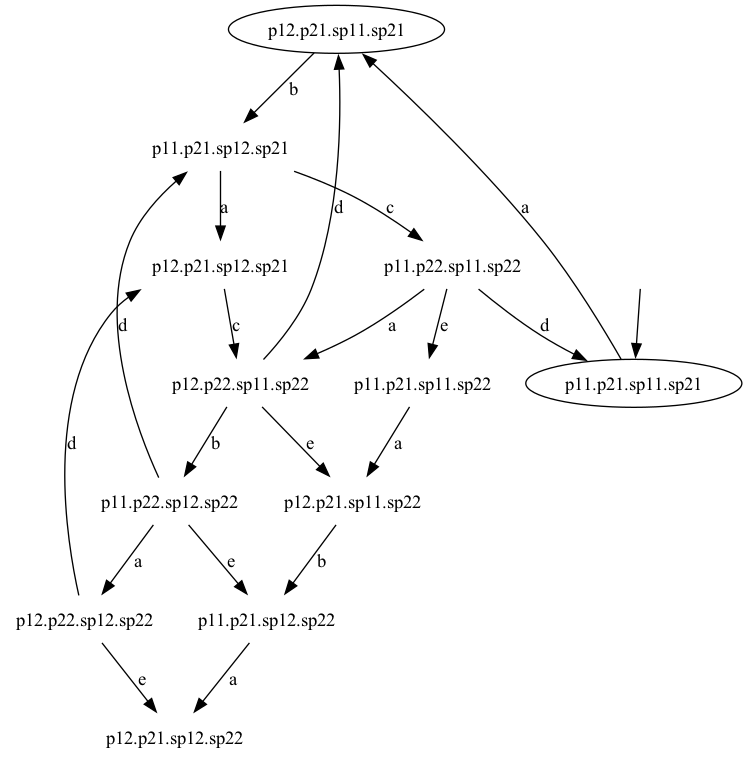

In [291]:
p1 = Automaton(states={'p11', 'p12'},
                init='p11',
                events={'a', 'b'},
                trans={Transition('p11', 'a', 'p12'), Transition('p12', 'b', 'p11')})
p2 = Automaton(states={'p21', 'p22'},
                init='p21',
                events={'c', 'd', 'e'},
                trans={Transition('p21', 'c', 'p22'), Transition('p22', 'd', 'p21'), Transition('p22', 'e', 'p21')})
sp1 = Automaton(states={'sp11', 'sp12'},
                init='sp11',
                events={'b', 'c'},
                trans={Transition('sp11', 'b', 'sp12'), Transition('sp12', 'c', 'sp11')},
                marked={'sp11'})
sp2 = Automaton(states={'sp21', 'sp22'},
                init='sp21',
                events={'c', 'd'},
                trans={Transition('sp21', 'c', 'sp22'), Transition('sp22', 'd', 'sp21')},
                marked={'sp21'})
def make_synchronized_automaton_S():
    """
    A little helper function to create the automaton of S.

    Define the automata p1, p2, sp1 and sp2 in here too.
    We will call this function later in the tests.
    """
    # YOUR CODE HERE 
    
    p1p2 = synch(p1,p2)
    sp1sp2 = synch(sp1,sp2)
    S = synch(p1p2, sp1sp2)
    return S

S = make_synchronized_automaton_S()
assert S.init == 'p11.p21.sp11.sp21', 'Please, follow this state naming convention and synchronization order!'
print(S)

plot_automaton(S, 'P1P2SP1SP2')

S = make_synchronized_automaton_S()
assert S.init == 'p11.p21.sp11.sp21', 'Please, follow this state naming convention and synchronization order!'

plot_automaton(S, 'P1P2SP1SP2')

In [292]:
reachable = reach(S.events, S.trans, {S.init}, set())
coreachable = coreach(S.events, S.trans, {S.init}, set())
blocking = S.states - (reachable & coreachable)
# YOUR CODE HERE


print('The blocking states are: ', blocking)
print(S.states - blocking)

The blocking states are:  {'p12.p21.sp12.sp22', 'p11.p21.sp12.sp22', 'p11.p21.sp11.sp22', 'p12.p21.sp11.sp22'}
{'p12.p22.sp12.sp22', 'p11.p22.sp12.sp22', 'p12.p21.sp12.sp21', 'p12.p22.sp11.sp22', 'p11.p22.sp11.sp22', 'p11.p21.sp12.sp21', 'p12.p21.sp11.sp21', 'p11.p21.sp11.sp21'}


In [293]:
assert type(make_synchronized_automaton_S()) is Automaton
assert reachable is not None
assert coreachable is not None
assert blocking is not None

## Task 3.2 - Modified Spec

* Modify the specifications to avoid any blocking states, and verify that no blocking states are achieved by showing that the reachable and coreachable states of *S* are the same for the modified specifications. ***[1p]***

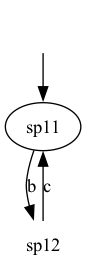

In [294]:
sp1_new = Automaton(states={'sp11', 'sp12'},
                init='sp11',
                events={'b', 'c', 'e'},
                trans={Transition('sp11', 'b', 'sp12'), Transition('sp12', 'c', 'sp11')},
                marked={'sp11'})

# YOUR CODE HERE

plot_automaton(sp1_new, 'SP1_new') 

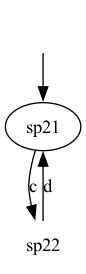

In [295]:
sp2_new = Automaton(states={'sp21', 'sp22'},
                init='sp21',
                events={'c', 'd'},
                trans={Transition('sp21', 'c', 'sp22'), Transition('sp22', 'd', 'sp21')},
                marked={'sp21'})

# YOUR CODE HERE

plot_automaton(sp2_new, 'SP2_new') 

The blocking states now are:  set()


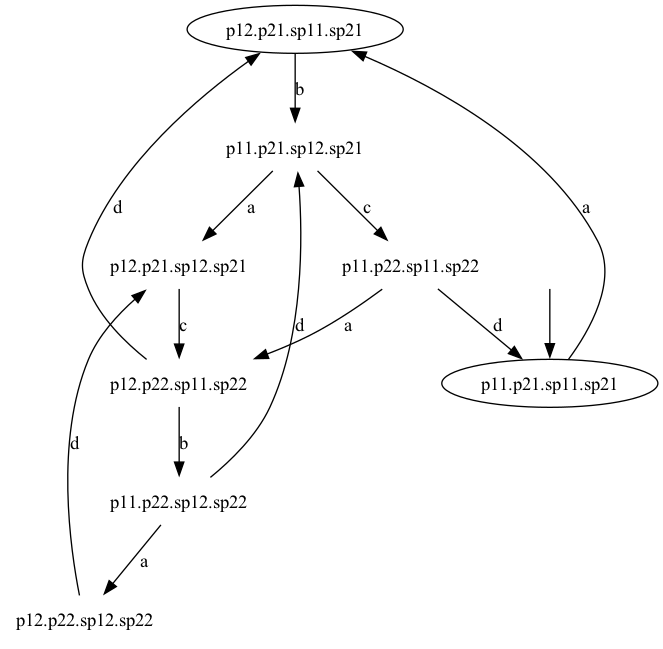

In [296]:
# Now synchronize with the new specifications
S_new = synch(synch(p1,p2), synch(sp1_new,sp2_new))
reachable_new = reach(S_new.events, S_new.trans, {S_new.init}, set())
coreachable_new = coreach(S_new.events, S_new.trans, {S_new.init}, set())
blocking_new = S_new.states - (reachable_new & coreachable_new)
# YOUR CODE HERE

print('The blocking states now are: ', blocking_new)
plot_automaton(S_new, 'S_new') 

In [297]:
assert type(S_new) is Automaton
assert reachable_new is not None
assert coreachable_new is not None
assert blocking_new is not None

- - -

# Task 4

## Synthesis ***[3p]***

Using `reach`, `coreach` and `synch`, your task is now to implement:

$\qquad$ `S = supervisor(P, Sp, sigma_u)`
    
that, given a plant $P$, a specification $Sp$ and a set of uncontrollable events $\Sigma_u$, generates a nonblocking and controllable supervisor $S$. Note that $\Sigma_u \subseteq \Sigma^P$, and it is assumed that $\Sigma^{Sp} \subseteq \Sigma^P$, where $\Sigma^P$ and $\Sigma^{Sp}$ are the event sets of the plant $P$ and the specification $Sp$. The supervisor is generated by implementing and applying algorithm 3 in the lecture notes.

Your code should raise a `ValueError` when there exist no supervisor that can fulfill the specification:

$\qquad$ `if noSupervisorExists: raise ValueError`

* *Note:* If more than one plant and/or specification model are involved, the total plant and/or specification model is generated by synchronizing the local models. For instance, $P_1, P_2, Sp_1$ and $Sp_2$ gives $P = P_1 \parallel P_2$ and $Sp = Sp_1 \parallel Sp_2$.

* *Note:* One of the input sets in Algorithm 3 is the set of forbidden states. Implement specifically a function that generates this forbidden state set, including both explicitly forbidden states and uncontrollable states.

* *Note:* In the synchronization of two automaton $A$ and $B$, the names of the original states $q^A$ and $q^B$ can be identified, since the merge state function generates state names $q^A.q^B$. Identification of the reachable states in $P \parallel Sp$ and the corresponding states in $P$ and $Sp$ simplifies the generation of the uncontrollable states. 

Here are some helper functions that might help you with your implementation of the algorithm in code.

In [298]:
# These two functions follow the definition of uncontrollable states given on page 100 in the Lecture Notes
def is_defined_for_p(p_trans, merged_source, shared_sigma_u):
    """
    Boolean check whether there is an uncontrollable transition defined in P
    with the merged_source as start state.
    
    :param p_trans: Set of transitions in automaton P
    :param merged_source: String label of the merged state in P||Q
    :param shared_sigma_u: Uncontrollable event shared between P and Q.
    """
    validate_inputs(p_trans, merged_source, shared_sigma_u)
    uncontrollable_trans = filter_trans_by_events(p_trans, shared_sigma_u)
    u_trans_from_merged_source = {t for t in uncontrollable_trans 
                                  if merged_source.startswith(str(t.source))}
    return u_trans_from_merged_source != set()


def is_defined_for_q(q_trans, merged_source, shared_sigma_u):
    """
    Boolean check whether there is an uncontrollable transition defined in Q
    with the merged_source as start state.
    
    :param q_trans: Set of transitions in automaton Q
    :param merged_source: String label of the merged state in P||Q
    :param shared_sigma_u: Uncontrollable event shared between P and Q.
    """
    validate_inputs(q_trans, merged_source, shared_sigma_u)
    uncontrollable_trans = filter_trans_by_events(q_trans, shared_sigma_u)
    u_trans_from_merged_source = {t for t in uncontrollable_trans 
                                  if merged_source.endswith(str(t.source))}
    return u_trans_from_merged_source != set()


def validate_inputs(trans, source, events):
    assert type(trans) is set
    assert all(type(t) is Transition for t in trans)
    
    assert type(source) is str

    assert type(events) is set
    assert all(type(e) in (str, int) for e in events)
    

In [299]:
# Now implement the function in code
def supervisor(P, Sp, sigma_u):
    """
    Generates a nonblocking and controllable supervisor for the synchronized system P||Sp.
    
    :param P: automaton of the plant
    :param Sp: automaton of the specification
    :param sigma_u: set of uncontrollable events
    """
    # YOUR CODE HERE
    S = synch(P, Sp)
    P_events = extract_elems_from_trans(P.trans, 'event')
    Sp_events = extract_elems_from_trans(Sp.trans, 'event')

    sigma_Sp = Sp.events
    sigma_P = P.events
    shared_sigma_u = sigma_Sp & sigma_P & sigma_u

    exclusive_sigma_u = (Sp_events - P_events) & sigma_u
    exclusive_sigma_u |= (P_events - Sp_events) & sigma_u

    single_event = filter_trans_by_events((P.trans -Sp.trans), exclusive_sigma_u)
    S_init = S.init

    unc_states = set()
    for state in S.states:
        P_unc = is_defined_for_p(P.trans, state, shared_sigma_u)
        Sp_unc = is_defined_for_q(Sp.trans, state, shared_sigma_u)
        reach_states = reach(S.events, S.trans, {state}, S.forbidden)

        if P_unc and not Sp_unc:
            unc_states.add(state)
        if P_unc and Sp_unc and single_event and filter_trans_by_events((P.trans | Sp.trans), exclusive_sigma_u) != set():
            unc_states.add(state)
        if (reach_states -{state}) == set() and (S.marked & {state}) == set() and S.marked !=set():
            unc_states.add(state)
        elif S.marked != set() and (S.marked & (reach_states - {state})) == set():
            unc_states.update(reach_states - {state})

    next_forbidden = set()
    Q_marked = {S.init} if S.marked == set() else S.marked
    while (next_forbidden & unc_states) != unc_states:
        Q_prime = coreach(S.events, S.trans, Q_marked, unc_states)
        next_forbidden = coreach(shared_sigma_u, filter_trans_by_events(S.trans, shared_sigma_u), (S.states - Q_prime), set())

    S_states = S.states - next_forbidden - S.forbidden
    if not S_states:
        S_states = {S_init}
    else:
        S_states.add(S_init)

    S_trans = filter_trans_by_source(filter_trans_by_target(S.trans, S_states), S_states)
    if S_states == set(): raise ValueError

    S = Automaton(states=S_states,
                  init=S_init,
                  events=S.events,
                  trans=S_trans,
                  marked=S_states & S.marked,
                  forbidden=set())
    return S

In [300]:
# Space for your own tests
P = Automaton(states={1, 2, 3, 4},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(3, 'b', 4)})
Sp1 = Automaton(states={1, 2, 3},
                init=1,
                events={'a', 'b'},
                trans={Transition(1, 'a', 2), Transition(2, 'b', 3)},
                marked={1, 2}) 
Sp2 = Automaton(states={1, 2, 3, 4},
                init=1,
                events={'a', 'b'},
                trans={Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(3, 'b', 4)},
                marked={1, 2})
S = supervisor(P, Sp1, {'b'})
assert S == supervisor(P, Sp2, {'b'})
assert S.states == {'1.1'}, 'TC 3.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 3.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 3.3 - got {} instead'.format(S.events)
assert S.trans == set(), 'TC 3.4 - got {} instead'.format(S.trans)
assert S.forbidden == set(), 'TC 3.4 - got {} instead'.format(S.forbidden)

In [301]:
# Test case 0 - Single states
P = Automaton(states={1},
              init=1,
              events=set(),
              trans=set())
Sp = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
S = supervisor(P, Sp, set())
assert type(S) is Automaton
assert S.states == {'1.2'}, 'TC 0.1 - got {} instead'.format(S.states)
assert S.events == set(), 'TC 0.2 - got {} instead'.format(S.events)

# Test case 1 - Three states
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3)})
Sp = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)})
S = supervisor(P, Sp, set())
assert S.states == {'1.1', '2.2', '3.2'}, 'TC 1.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 1.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 1.3 - got {} instead'.format(S.events)
assert S.forbidden == set(), 'TC 1.4 - got {} instead'.format(S.forbidden)

# Test case 2 - Three states and an uncontrolable event
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3)})
Sp = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)})
S = supervisor(P, Sp, {'b'})
assert S.states == {'1.1'}, 'TC 2.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 2.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 2.3 - got {} instead'.format(S.events)
assert S.forbidden == set(), 'TC 2.4 - got {} instead'.format(S.forbidden)

# Test case 3 - Two uncontrollable transitions in a sequence
P = Automaton(states={1, 2, 3, 4},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(3, 'b', 4)})
Sp1 = Automaton(states={1, 2, 3},
                init=1,
                events={'a', 'b'},
                trans={Transition(1, 'a', 2), Transition(2, 'b', 3)},
                marked={1, 2}) 
Sp2 = Automaton(states={1, 2, 3, 4},
                init=1,
                events={'a', 'b'},
                trans={Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(3, 'b', 4)},
                marked={1, 2})
S = supervisor(P, Sp1, {'b'})
assert S == supervisor(P, Sp2, {'b'})
assert S.states == {'1.1'}, 'TC 3.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 3.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 3.3 - got {} instead'.format(S.events)
assert S.trans == set(), 'TC 3.4 - got {} instead'.format(S.trans)
assert S.forbidden == set(), 'TC 3.4 - got {} instead'.format(S.forbidden)

# Test case 4 - Two uncontrollable transitions in parallel
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b', 'c'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(2, 'c', 3)})
Sp = Automaton(states={1, 2, 3},
               init=1,
               events={'a', 'b', 'c'},
               trans={Transition(1, 'a', 2), Transition(2, 'b', 3)})
S = supervisor(P, Sp, {'b', 'c'})
assert S.states == {'1.1'}, 'TC 4.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 4.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b', 'c'}, 'TC 4.3 - got {} instead'.format(S.events)
assert S.forbidden == set(), 'TC 4.4 - got {} instead'.format(S.forbidden)

# Example 7.5 on p. 113 in the Lecture Notes
P1 = Automaton(states={'p11', 'p12'}, 
               init='p11',
               events={'a', 'b'},
               trans={Transition('p11', 'a', 'p12'),
                      Transition('p12', 'b', 'p11')})   
P2 = Automaton(states={'p21', 'p22'},
               init='p21',
               events={'c', 'd', 'e'},
               trans={Transition('p21', 'c', 'p22'),
                      Transition('p22', 'd', 'p21'),
                      Transition('p22', 'e', 'p21')})
SP1 = Automaton(states={'sp11', 'sp12'},
                init='sp11',
                events={'b', 'c'},
                trans={Transition('sp11', 'b', 'sp12'),
                       Transition('sp12', 'c', 'sp11')},
                marked={'sp11'})   
SP2 = Automaton(states={'sp21', 'sp22'},
                init='sp21',
                events={'c', 'd'},
                trans={Transition('sp21', 'c', 'sp22'),
                       Transition('sp22', 'd', 'sp21')},
                marked={'sp21'})   
Sp = synch(SP1, SP2)
P = synch(P1, P2)
S = supervisor(P, Sp, {'b'})
assert S.states == {'p11.p22.sp12.sp22', 'p11.p21.sp11.sp21', 'p11.p21.sp12.sp21', 
                    'p12.p21.sp11.sp21', 'p11.p22.sp11.sp22', 'p12.p22.sp11.sp22'}, '\
                    Got {} instead'.format(S.states)
assert S.init == 'p11.p21.sp11.sp21', 'Got {} instead'.format(S.init)
assert S.events == {'a', 'b', 'c', 'd', 'e'}, 'Got {} instead'.format(S.events)
assert S.trans == {
            Transition(source='p11.p21.sp11.sp21', event='a', target='p12.p21.sp11.sp21'),
            Transition(source='p11.p22.sp12.sp22', event='d', target='p11.p21.sp12.sp21'),
            Transition(source='p12.p21.sp11.sp21', event='b', target='p11.p21.sp12.sp21'),
            Transition(source='p11.p22.sp11.sp22', event='a', target='p12.p22.sp11.sp22'),
            Transition(source='p12.p22.sp11.sp22', event='d', target='p12.p21.sp11.sp21'),
            Transition(source='p11.p21.sp12.sp21', event='c', target='p11.p22.sp11.sp22'),
            Transition(source='p12.p22.sp11.sp22', event='b', target='p11.p22.sp12.sp22'),
            Transition(source='p11.p22.sp11.sp22', event='d', target='p11.p21.sp11.sp21')
        }, 'Got {} instead'.format(S.trans)
assert S.marked == {'p11.p21.sp11.sp21', 'p12.p21.sp11.sp21'}, 'Got {} instead'.format(S.marked)
assert S.forbidden == set(), 'Got {} instead'.format(S.forbidden)
### BEGIN HIDDEN TESTS
# Test case 5
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3)})
Sp = Automaton(states={1, 2, 3},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2), Transition(2, 'b', 3)},
               marked={2})
S = supervisor(P, Sp, set())
assert S.states == {'1.1', '2.2'}, 'TC 5.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 5.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 5.3 - got {} instead'.format(S.events)
assert S.marked == {'2.2'}, 'TC 5.4 - got {} instead'.format(S.marked)
assert S.forbidden == set(), 'TC 5.5 - got {} instead'.format(S.forbidden)

# Test case 6
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3)})
Sp = Automaton(states={1, 2, 3},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2), Transition(2, 'b', 3)},
               marked={1, 2})
S = supervisor(P, Sp, {'b'})
assert S.states == {'1.1'}, 'TC 6.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 6.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 6.3 - got {} instead'.format(S.events)
assert S.marked == {'1.1'}, 'TC 6.4 - got {} instead'.format(S.marked)
assert S.forbidden == set(), 'TC 6.5 - got {} instead'.format(S.forbidden)

# Example 7.6 on p. 114 in the Lecture Notes
P = Automaton(states={'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8'}, 
              init='p1',
              events={'a', 'b', 'c', 'd'},
              trans={Transition('p1', 'a', 'p2'),
                     Transition('p1', 'c', 'p3'),
                     Transition('p3', 'd', 'p4'),
                     Transition('p2', 'b', 'p4'),
                     Transition('p2', 'd', 'p5'),
                     Transition('p5', 'a', 'p6'),
                     Transition('p6', 'b', 'p4'),
                     Transition('p6', 'd', 'p7'),
                     Transition('p7', 'd', 'p8')},
              marked={'p4'})   
Sp = Automaton(states={'q1','q2', 'q3', 'q4', 'q5', 'q6', 'q7'},
               init='q1',
               events={'a', 'b', 'c', 'd'},
               trans={Transition('q1', 'a', 'q2'),
                     Transition('q1', 'c', 'q3'),
                     Transition('q3', 'd', 'q4'),
                     Transition('q2', 'b', 'q4'),
                     Transition('q2', 'd', 'q5'),
                     Transition('q5', 'a', 'q6'),
                     Transition('q6', 'b', 'q4'),
                     Transition('q6', 'd', 'q7')},
               marked={'q4'})      
S = supervisor(P, Sp, {'d'})
assert S.states == {'p3.q3', 'p1.q1', 'p4.q4'}, 'Got {} instead'.format(S.states)
assert S.init == 'p1.q1', 'Got {} instead'.format(S.init)
assert S.events == {'b', 'a', 'd', 'c'}, 'Got {} instead'.format(S.events)
assert S.trans == {
    Transition(source='p3.q3', event='d', target='p4.q4'), 
    Transition(source='p1.q1', event='c', target='p3.q3')
}, 'Got {} instead'.format(S.trans)
assert S.marked == {'p4.q4'}, 'Got {} instead'.format(S.marked)
assert S.forbidden == set(), 'Got {} instead'.format(S.forbidden)

# Exam Oct 2015 - Task 3
P = Automaton(states={1, 2, 3, 4, 5, 6, 7, 8, 9}, 
              init=1,
              events={'a', 'b', 'c', 'd', 'e'},
              trans={Transition(1, 'a', 2),
                     Transition(1, 'c', 3),
                     Transition(1, 'b', 4),
                     Transition(2, 'c', 5),
                     Transition(3, 'd', 6),
                     Transition(4, 'c', 7),
                     Transition(5, 'b', 6),
                     Transition(5, 'd', 6),
                     Transition(7, 'a', 6),
                     Transition(7, 'e', 8),
                     Transition(8, 'c', 9),
                     Transition(9, 'd', 6)})   
Sp = Automaton(states={1, 2, 3, 4},
               init=1,
               events={'a', 'b', 'd'},
               trans={Transition(1, 'a', 2),
                     Transition(1, 'b', 3),
                     Transition(1, 'd', 4),
                     Transition(2, 'b', 4),
                     Transition(3, 'a', 4)},
               marked={4})      
S = supervisor(P, Sp, {'d', 'e'})
assert len(S.states) == 3, 'Got {} instead'.format(S.states)
assert len(S.trans) == 2, 'Got {} instead'.format(S.trans)
assert len(S.marked) == 1, 'Got {} instead'.format(S.marked)
assert {'c', 'd'} == extract_elems_from_trans(S.trans, 'event'), 'Got {} instead'.format(S.trans)

# Test case 7
def TC7():
    P = Automaton(states={1, 2}, init=1, events={'a'}, trans={Transition(1, 'a', 2)})
    Sp = Automaton(states={1}, init=1, events={'a'}, trans=set(), marked={1})
    try:
        supervisor(P, Sp, {'a'})  # This is supposed to fail
        return False
    except ValueError as e:
        return True
    except Exception as e:
        print(e)
        return False

assert TC7(), 'TC 7 - Should raise a ValueError when no supervisor is available'
### END HIDDEN TESTS

AssertionError: TC 4.1 - got {'3.3', '1.1'} instead

---

# Task 5 

## Stick Picking Game ***[1p]***

Two people named **A** and **B** are playing a simple game. A number of sticks are lain
out on the ground and the players take alternately one or two sticks. Note that at least
one stick must be picked. The player that ends up with the last stick has lost the game.
Player **A** is always the one that starts picking sticks. A related problem is introduced
in Task 6.3 in the LLD-exercises.

* Model this game by an automaton `P`, with an initial number of five sticks. Hint: identify the events and the states.

* Create a specification `Sp` by introducing a marked state in `P`, specifying that player **A** is to win and player **B** is to loose. Remember that the player left with only the final stick to pick, is the loser.

* Generate by the algorithm in *Task 4* a supervisor `S` which guarantees that player **A** wins the game, i.e `S = supervisor(P, Sp, sigma_u)`. *Note* that the set of uncontrollable events `sigma_u` must first be decided.

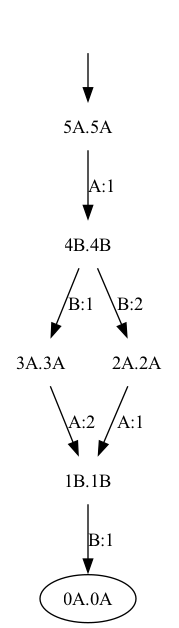

In [ ]:
# YOUR CODE HERE
P = Automaton(states= {'5A','4A','3A', '2A', '1A', '0A','4B','3B','2B', '1B', '0B'},
              init= '5A',
              events= {'A:1', 'A:2', 'B:1', 'B:2'},
              trans= {Transition('5A','A:1','4B'), Transition('5A','A:2','3B'), Transition('3A','A:1','2B'), Transition('3A' ,'A:2', '1B'),Transition('2A' ,'A:1', '1B'), Transition('2A' ,'A:1', '0B'), Transition('1A' ,'A:1', '0B'),
                      Transition('4B', 'B:1','3A'), Transition('4B', 'B:2','2A'), Transition('3B', 'B:1','2A'), Transition('3B', 'B:2','1A'), Transition('2B', 'B:1','1A'),Transition('2B', 'B:2','0A'), Transition('1B', 'B:1','0A')}
                      )
Sp = Automaton(states= {'5A','4A','3A', '2A', '1A', '0A','4B','3B','2B', '1B', '0B'},
              init= '5A',
              events= {'A:1', 'A:2', 'B:1', 'B:2'},
              trans= {Transition('5A','A:1','4B'), Transition('5A','A:2','3B'), Transition('3A','A:1','2B'), Transition('3A', 'A:2', '1B'), Transition('2A', 'A:1', '1B'), Transition('2A','A:1','0B'), Transition('1A' ,'A:1', '0B'),
                      Transition('4B', 'B:1','3A'), Transition('4B', 'B:2','2A'), Transition('3B', 'B:1','2A'), Transition('3B', 'B:2','1A'), Transition('2B', 'B:1','1A'),Transition('2B', 'B:2','0A'), Transition('1B', 'B:1','0A')},
              marked={'0A'},
              forbidden={'0B'})
synched = synch(P,Sp)
sigma_u = ({'B:1','B:2'})
S = supervisor(P, Sp, sigma_u)
plot_automaton(S, 'S_3_15')

In [ ]:
assert type(P) is Automaton
assert type(Sp) is Automaton
assert type(S) is Automaton

assert P.states == Sp.states
assert P.events == Sp.events
assert P.init == Sp.init
assert P.trans == Sp.trans
assert P.marked == set() or P.marked == P.states
assert len(Sp.marked) == 1

- - -

Congratulations! You have reached the end of the assignment. Now,

* Save the notebook
* Upload the .ipynb file to Canvas
* Enjoy the rest of the day! 